In [10]:
import pandas as pd
import ast
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

# 1. 讀 CSV
df = pd.read_csv('D:\\es\\Hierarchical clustering\\transactions_cluster_95threshold_post30y.csv')

# 把字串轉回 list
transactions = df['transaction'].apply(ast.literal_eval).tolist()

# -----------------------------
# 轉成 one-hot 編碼並做 FP-Growth
# -----------------------------
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_te = pd.DataFrame(te_ary, columns=te.columns_)

min_support = 0.06  # 可依需求調整
# min_support = 0.05  # 可依需求調整
freq_items = fpgrowth(df_te, min_support=min_support, use_colnames=True)

print(freq_items)

        support                                           itemsets
0      0.166667                                    (27.625_82.375)
1      0.156863                                    (27.625_72.375)
2      0.117647                                    (27.625_67.375)
3      0.107843                                     (22.625_7.375)
4      0.098039                                  (22.625_-102.625)
...         ...                                                ...
15403  0.068627    (62.625_157.375, 57.625_57.375, 67.625_167.375)
15404  0.068627  (62.625_157.375, 57.625_57.375, 67.625_167.375...
15405  0.068627    (57.625_62.375, 67.625_167.375, 62.625_162.375)
15406  0.068627    (57.625_62.375, 62.625_157.375, 67.625_167.375)
15407  0.068627  (57.625_62.375, 62.625_157.375, 67.625_167.375...

[15408 rows x 2 columns]


In [11]:
# 6. 轉回經緯度 (DataFrame 展開)
def parse_latlon(item):
    lat, lon = item.split("_")
    return float(lat), float(lon)

records = []
for _, row in freq_items.iterrows():
    itemset = list(row['itemsets'])
    coords = [parse_latlon(item) for item in itemset]
    records.append({
        "itemset": itemset,
        "latitudes": [lat for lat, _ in coords],
        "longitudes": [lon for _, lon in coords],
        "support": row['support']
    })

frequent_itemsets_with_coords = pd.DataFrame(records)

# 7. 儲存結果
# frequent_itemsets_with_coords.to_csv("D:\\es\\frequent_itemset\\frequent_itemsets_95threshold_pre30y.csv", index=False)

print("✅ frequent itemsets 已轉換成經緯度並存檔")
print(frequent_itemsets_with_coords.head())
print('總筆數：', len(frequent_itemsets_with_coords))

✅ frequent itemsets 已轉換成經緯度並存檔
             itemset latitudes  longitudes   support
0    [27.625_82.375]  [27.625]    [82.375]  0.166667
1    [27.625_72.375]  [27.625]    [72.375]  0.156863
2    [27.625_67.375]  [27.625]    [67.375]  0.117647
3     [22.625_7.375]  [22.625]     [7.375]  0.107843
4  [22.625_-102.625]  [22.625]  [-102.625]  0.098039
總筆數： 15408


In [13]:
from mlxtend.frequent_patterns import association_rules

# -----------------------
# 4️⃣ 生成關聯規則
# -----------------------
rules = association_rules(freq_items, metric="confidence", min_threshold=0.20)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
print('總筆數：', len(rules))
# rules.to_csv('D:\\es\\frequent_itemset\\association_rules_full_post30y.csv', index=False)

                             antecedents  \
0                        (27.625_72.375)   
1                        (27.625_67.375)   
2                         (22.625_7.375)   
3                        (22.625_12.375)   
4                        (27.625_82.375)   
...                                  ...   
373671  (67.625_167.375, 62.625_162.375)   
373672                   (57.625_62.375)   
373673                  (62.625_157.375)   
373674                  (67.625_167.375)   
373675                  (62.625_162.375)   

                                             consequents   support  \
0                                        (27.625_67.375)  0.098039   
1                                        (27.625_72.375)  0.098039   
2                                        (22.625_12.375)  0.078431   
3                                         (22.625_7.375)  0.078431   
4                                        (27.625_77.375)  0.068627   
...                                                

In [6]:
import numpy as np
from tqdm import tqdm

# 假設 rules['antecedents'] 和 rules['consequents'] 是 set of "lat_lon" 字串

def compute_center_with_progress(sets_series):
    centers = []
    for coords_set in tqdm(sets_series, total=len(sets_series), desc="Computing centers"):
        if not coords_set:
            centers.append((np.nan, np.nan))
            continue
        coords_array = np.array([list(map(float, i.split('_'))) for i in coords_set])
        lat_mean = np.mean(coords_array[:, 0])
        lon_mean = np.mean(coords_array[:, 1])
        centers.append((lat_mean, lon_mean))
    return zip(*centers)

# 計算 antecedents 中心
rules['ante_lat'], rules['ante_lon'] = compute_center_with_progress(rules['antecedents'])

# 計算 consequents 中心
rules['cons_lat'], rules['cons_lon'] = compute_center_with_progress(rules['consequents'])

Computing centers: 100%|██████████| 16/16 [00:00<00:00, 15989.72it/s]


In [7]:
from tqdm import tqdm

# 確保 tqdm 可以和 pandas 互動
tqdm.pandas(desc="Parsing antecedent coords")
rules['ante_coords'] = rules['antecedents'].progress_apply(
    lambda coord_set: [tuple(map(float, s.split('_'))) for s in coord_set]
)

tqdm.pandas(desc="Parsing consequent coords")
rules['cons_coords'] = rules['consequents'].progress_apply(
    lambda coord_set: [tuple(map(float, s.split('_'))) for s in coord_set]
)

Parsing consequent coords: 100%|██████████| 16/16 [00:00<?, ?it/s]


In [36]:
# 中心點
target_lat = 62.625
target_lon = 72.375
range_deg = 10  # ±5度

# 定義範圍
lat_range = (target_lat - range_deg, target_lat + range_deg)
lon_range = (target_lon - range_deg, target_lon + range_deg)

# 定義函數：只要 ante_coords 中有一個點落在 ±5 度內，就算符合
def in_latlon_range(coord_list):
    return any(
        lat_range[0] <= lat <= lat_range[1] and lon_range[0] <= lon <= lon_range[1]
        for lat, lon in coord_list
    )

# 篩選規則
nearby_rules = rules[rules['ante_coords'].apply(in_latlon_range)]

In [6]:
# 你關注的經緯度列表
target_coords = [
    # (27.625, 82.375),
    # (72.625, -107.625),
    # (52.625, 77.375),
    (52.625, 27.375)
]

target_set = set(target_coords)  # 為了加快查找效率

# 定義函數：只要 ante_coords 中有一個在 target_set 就算符合
def contains_target(coord_list):
    return any((lat, lon) in target_set for lat, lon in coord_list)

# 篩選 ante_coords 中包含目標經緯度的規則
nearby_rules = rules[rules['ante_coords'].apply(contains_target)]

In [7]:
print(f"找到 {len(nearby_rules)} 條規則，antecedents 中心在緯度約 50、經度約 60 的範圍內：")
print(nearby_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

找到 291839 條規則，antecedents 中心在緯度約 50、經度約 60 的範圍內：
                             antecedents  \
26                       (52.625_27.375)   
46       (52.625_27.375, 62.625_122.375)   
47        (52.625_27.375, 62.625_52.375)   
49                       (52.625_27.375)   
52       (62.625_112.375, 52.625_27.375)   
...                                  ...   
2481098   (52.625_27.375, 52.625_17.375)   
2481099  (67.625_167.375, 52.625_27.375)   
2481100  (62.625_172.375, 52.625_27.375)   
2481101  (52.625_27.375, 62.625_122.375)   
2481124                  (52.625_27.375)   

                                               consequents   support  \
26                                        (62.625_122.375)  0.098039   
46                                         (62.625_52.375)  0.058824   
47                                        (62.625_122.375)  0.058824   
49                         (62.625_52.375, 62.625_122.375)  0.058824   
52                                        (62.625_122.375)  0.

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# 1. 創建地圖
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# 標籤控制
ante_plotted = False
cons_plotted = False

# 2. 迭代 nearby_rules 繪圖
for idx, row in nearby_rules.iterrows():
    ante_coords = row['ante_coords']
    cons_coords = row['cons_coords']
    
    if isinstance(ante_coords, list) and isinstance(cons_coords, list):
        for (lat1, lon1) in ante_coords:
            # 標記前事件座標
            label = 'Antecedent' if not ante_plotted else None
            ax.plot(lon1, lat1, 'ro', markersize=3, transform=ccrs.PlateCarree(), label=label)
            ante_plotted = True
            
            for (lat2, lon2) in cons_coords:
                # 標記後事件座標
                label = 'Consequent' if not cons_plotted else None
                ax.plot(lon2, lat2, 'go', markersize=3, transform=ccrs.PlateCarree(), label=label)
                cons_plotted = True
                
                # 繪製連線
                ax.plot([lon1, lon2], [lat1, lat2],
                        color='blue', linewidth=0.5, alpha=0.3, transform=ccrs.PlateCarree())

# 顯示 legend，只會顯示一次
ax.legend(loc='lower left')
plt.title('Teleconnection Map from nearby_rules \n Pre 30 Years (1965-1994)')
# 指定輸出資料夾
out_dir = "D:\\es\\frequent_itemset"

# plt.savefig(
#     os.path.join(out_dir, 'pre30y(27.625, 82.375).png')
#     , dpi=300, bbox_inches='tight')
plt.show()

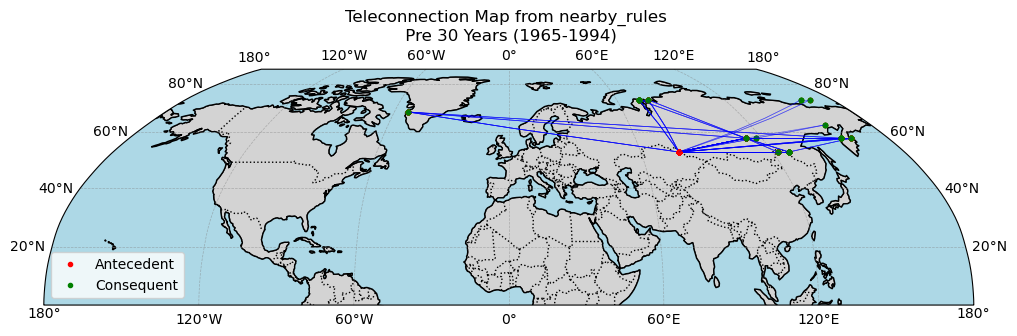

In [47]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# 1. 創建地圖
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# 標籤控制
ante_plotted = False
cons_plotted = False

# 2. 迭代 nearby_rules 繪圖
for idx, row in nearby_rules.iterrows():
    ante_coords = row['ante_coords']
    cons_coords = row['cons_coords']
    
    if isinstance(ante_coords, list) and isinstance(cons_coords, list):
        for (lat1, lon1) in ante_coords:
            # 標記前事件座標
            label = 'Antecedent' if not ante_plotted else None
            ax.plot(lon1, lat1, 'ro', markersize=3, transform=ccrs.PlateCarree(), label=label)
            ante_plotted = True
            
            for (lat2, lon2) in cons_coords:
                # 標記後事件座標
                label = 'Consequent' if not cons_plotted else None
                ax.plot(lon2, lat2, 'go', markersize=3, transform=ccrs.PlateCarree(), label=label)
                cons_plotted = True
                
                # 繪製連線
                ax.plot([lon1, lon2], [lat1, lat2],
                        color='blue', linewidth=0.5, alpha=0.3, transform=ccrs.PlateCarree())

# 顯示 legend，只會顯示一次
ax.legend(loc='lower left')
plt.title('Teleconnection Map from nearby_rules \n Pre 30 Years (1965-1994)')
# 指定輸出資料夾
# out_dir = "D:\\es\\association_rule"

# plt.savefig(
#     os.path.join(out_dir, 'pre30y(52.625, 77.375).png')
#     , dpi=300, bbox_inches='tight')
plt.show()